## Libraries/Loading datasets

In [ ]:
#installing library to help import the huggingface dataset
!pip -q install datasets

In [ ]:
#basic libraries to help with the process
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import load_dataset
import re
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

In [ ]:
#setting the option to be able to read the full text
pd.set_option("display.max_colwidth", None)

In [ ]:
#setting up a random seed
SEED = 36

In [ ]:
#loading the datasets
train = load_dataset("sh0416/ag_news", split="train")
test  = load_dataset("sh0416/ag_news", split="test")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
#making them pandas datasets (easier to work with)
train_start = pd.DataFrame(train)
test = pd.DataFrame(test)

## Preprocessing

In [ ]:
#checking if any nulls in dataset
train_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        120000 non-null  int64 
 1   title        120000 non-null  object
 2   description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        7600 non-null   int64 
 1   title        7600 non-null   object
 2   description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.3+ KB


In [ ]:
#first look at the dataset
#notice how there seems to be some "\" in between words in some of the descriptions, we'll have to fix that
print(train_start)

        label  \
0           3   
1           3   
2           3   
3           3   
4           3   
...       ...   
119995      1   
119996      2   
119997      2   
119998      2   
119999      2   

                                                                            title  \
0                               Wall St. Bears Claw Back Into the Black (Reuters)   
1                             Carlyle Looks Toward Commercial Aerospace (Reuters)   
2                                 Oil and Economy Cloud Stocks' Outlook (Reuters)   
3                    Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)   
4       Oil prices soar to all-time record, posing new menace to US economy (AFP)   
...                                                                           ...   
119995                         Pakistan's Musharraf Says Won't Quit as Army Chief   
119996                                          Renteria signing a top-shelf deal   
119997                        

In [ ]:
#combining title and description (more info)
title = train_start["title"].astype(str)
desc = train_start["description"].astype(str)

#removing the "\"
title = title.str.replace("\\", " ", regex=False)
desc = desc.str.replace("\\", " ", regex=False)

#we can add weights later if necessary
train_start["x_text"] = title + " " + desc

#lower case (import for word count)
train_start["x_text"] = train_start["x_text"].str.lower()

#doing the same for test split

title = test["title"].astype(str)
desc = test["description"].astype(str)

title = title.str.replace("\\", " ", regex=False)
desc = desc.str.replace("\\", " ", regex=False)

test["x_text"] = title + " " + desc

test["x_text"] = test["x_text"].str.lower()

In [ ]:
#the combined text
print(train_start["x_text"].head())

0                                                                                                                              wall st. bears claw back into the black (reuters) reuters - short-sellers, wall street's dwindling band of ultra-cynics, are seeing green again.
1    carlyle looks toward commercial aerospace (reuters) reuters - private investment firm carlyle group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.
2                                      oil and economy cloud stocks' outlook (reuters) reuters - soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums.
3              iraq halts oil exports from main southern pipeline (reuters) reuters - authorities have halted oil export flows from the main pipeline in southern iraq after intelligenc

In [ ]:
#splits the train set into train and validation on a 90/10 split, this split is with seed 36
train, val = train_test_split(train_start, test_size=0.1, random_state = SEED)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108000 entries, 48297 to 94853
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        108000 non-null  int64 
 1   title        108000 non-null  object
 2   description  108000 non-null  object
 3   x_text       108000 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.1+ MB


## Metrics

In [ ]:
#setting up accuracy function
def accuracy(y_true, y_pred):
    #set y_true and y_pred as numpy arrays so we can use (i, len(y_pred)) as positional arguments
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    #initialize correct prediction count as 0
    same = 0
    for i in range(len(y_pred)):
        if y_true[i] == y_pred[i]:
            #if prediction was right, increse the count
            same += 1
    #return the accuracy
    return same / len(y_pred)

#setting a function that returns True Positives, True Negatives, False Positives and False Negatives, per label
def metrics(label, y_true, y_pred):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == label and yp == label:
            tp += 1
        elif yt != label and yp == label:
            fp += 1
        elif yt == label and yp != label:
            fn += 1
        else:
            tn += 1
    return tp, fp, fn, tn

#calculates the f1-score given a label
def f1(label, y_true, y_pred):
    tp, fp, fn, tn = metrics(label, y_true, y_pred)
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    return 2 * (precision * recall) / (precision + recall)


#calculates the macro f1 (average f1)
def macro_f1(y_true, y_pred):
    labels = sorted(set(y_true) | set(y_pred))
    sum = 0
    for label in labels:
        sum += f1(label, y_true, y_pred)
    return sum / 4

# uses sklearn's confusion matrix function
def conf_matrix(y_true, y_pred, class_names=["World", "Sports", "Business", "Sci/Tech"], normalize=False, save_path=None):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(
        cmap="Blues",
        values_format=".2f" if normalize else "d",
        ax=ax,
        colorbar=True
    )

    #ax.set_title("Normalized Confusion Matrix (Test Set)" if normalize else "Confusion Matrix (Test Set)")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


## TF-IDF

Feature extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Creating feature vectors with TF-IDF...")
# Setting up TF-IDF with 10k features and removing common stop words
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

# Transforming the data - only fitting on train to avoid leaking info
X_train = vectorizer.fit_transform(train['x_text'])
X_dev = vectorizer.transform(val['x_text'])
X_test = vectorizer.transform(test['x_text'])

# Target labels
y_train = train['label']
y_dev = val['label']
y_test = test['label']

print(f"Vectors created with {X_train.shape[1]} features.")

Done! Vectors created with 10000 features.


Model training

In [ ]:
#sets up a grid search for parameter c
c_grid = {"C": [0.1, 1, 10]}
# Baseline 1: Logistic Regression
# Added more iterations so it doesn't complain about convergence
lr_clf = LogisticRegression(max_iter=1000)
lr_clf = GridSearchCV(lr_clf, c_grid, cv=5, scoring="accuracy")
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_dev)

# Baseline 2: Linear SVM
# Usually more solid for text classification
svm_clf = LinearSVC(random_state=SEED)
svm_clf = GridSearchCV(svm_clf, c_grid, cv=5, scoring="accuracy")
svm_clf.fit(X_train, y_train)
svm_preds = svm_clf.predict(X_dev)

print("Models trained.")
print(f"LR Acc: {accuracy(y_dev, lr_preds):.4f}")
print(f"SVM Acc: {accuracy(y_dev, svm_preds):.4f}")

Models trained.
LR Acc: 0.9077
SVM Acc: 0.9099


In [ ]:
print(f"LR Macro F1: {macro_f1(y_dev, lr_preds):.4f}")
print(f"SVM Macro F1: {macro_f1(y_dev, svm_preds):.4f}")

LR Macro F1: 0.9081
SVM Macro F1: 0.9103


In [ ]:
print(f"LR best value for C: {lr_clf.best_params_}")
print(f"SVM best value for C: {svm_clf.best_params_}")

LR best value for C: {'C': 1}
SVM best value for C: {'C': 0.1}


Final Results & Error Analysis

--- Final Scores ---
Test Acc using SVM: 0.9147
Test Macro-F1 using SVM: 0.9145


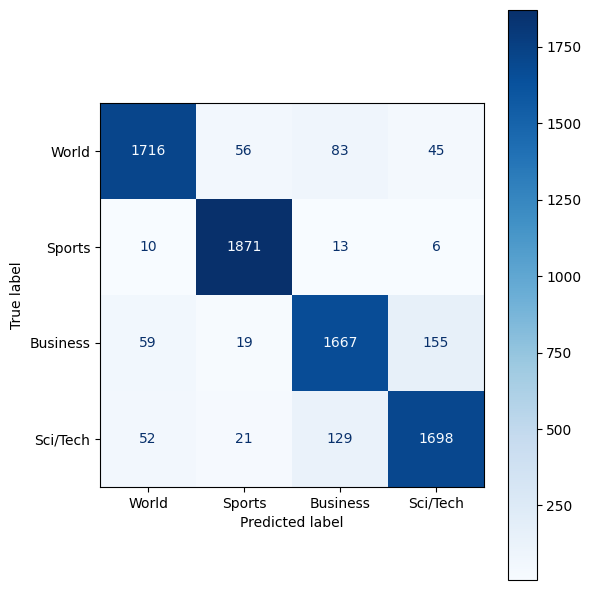

None

--- Examples of mistakes ---
Mistake #1:
Label was: Sci/Tech | Model said: Sports
Text: newmont mining shuts down peru mine after road blockade, protests denver newmont mining corporation temporarily shut down a mine in peru today after a two-week blockade of a road t...
---------------
Mistake #2:
Label was: Sci/Tech | Model said: Business
Text: eu, iran clash over terms of nuclear freeze just 3 days after it came into force, the head of the un atomic watchdog says. iranian denials has long accused tehran of trying to buil...
---------------
Mistake #3:
Label was: Sci/Tech | Model said: Business
Text: hundreds die in filipino storm more than 200 people are feared dead as a result of flash floods and landslides triggered by a storm in the philippines, officials say....
---------------
Mistake #4:
Label was: Sci/Tech | Model said: Business
Text: google shares just may be winners after all wall street, which forced google, the internet search engine, to lower the price of its share

In [ ]:
# Final check on the test set using the SVM
test_predictions = svm_clf.predict(X_test)

print("--- Final Scores ---")
print(f"Test Acc using SVM: {accuracy(y_test, test_predictions):.4f}")
print(f"Test Macro-F1 using SVM: {macro_f1(y_test, test_predictions):.4f}")

# Confusion matrix to see the overlap between classes
print(conf_matrix(y_test, test_predictions))

# Error analysis: pulling 20 random-ish mistakes to check manually
# Just mapping numbers to names so I can actually read it
class_names = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}
wrong_idx = [i for i, (p, a) in enumerate(zip(test_predictions, y_test)) if p != a]

print("\n--- Examples of mistakes ---")
for i in range(min(20, len(wrong_idx))):
    idx = wrong_idx[i]
    print(f"Mistake #{i+1}:")
    print(f"Label was: {class_names[y_test.iloc[idx]]} | Model said: {class_names[test_predictions[idx]]}")
    print(f"Text: {val.iloc[idx]['x_text'][:180]}...")
    print("-" * 15)

In [ ]:
def show_confusion_examples(val_df, y_true, y_pred, class_names, pairs, k=10, seed=0, text_col="x_text", max_chars=180):
    rng = np.random.default_rng(seed)

    # make them plain arrays for safe indexing
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    for pred_label, true_label in pairs:
        idx = np.where((y_pred == pred_label) & (y_true == true_label))[0]

        print(f"\n=== predicted={class_names[pred_label]} | true={class_names[true_label]} | count={len(idx)} ===")
        if len(idx) == 0:
            continue

        take = idx if len(idx) <= k else rng.choice(idx, size=k, replace=False)

        for j, ix in enumerate(take, 1):
            print(f"#{j}: true={class_names[true_label]} | pred={class_names[pred_label]}")
            print(val_df.iloc[ix][text_col][:max_chars] + "...")
            print("-" * 15)

# example pairs: 10 examples for each confusion type you pick
pairs = [
    (2, 1),  # predicted Sports, true World
    (2, 3),
    (2, 4),
    (1, 3),
    (1, 2), # predicted World, true Sports
    (1, 4),
    (3, 1),
    (3, 2),
    (3, 4),  # predicted Business, true Sci/Tech
    (4, 1),
    (4, 2),
    (4, 3),  # predicted Sci/Tech, true Business
]

show_confusion_examples(val, y_dev, svm_preds, class_names, pairs, k=10, seed=SEED)


=== predicted=Sports | true=World | count=79 ===
#1: true=World | pred=Sports
the division is almost in the yankees' hands after a doubleheader sweep of the minnesota twins, the yankees can clinch the a.l. east championship on thursday by beating them again....
---------------
#2: true=World | pred=Sports
teen's goal gives u.s. shot at soccer gold iraklion, greece - the only teenager on the u.s. women's soccer team gave the old vets a chance to leave with one last gold......
---------------
#3: true=World | pred=Sports
chiefs lead ravens in fourth quarter baltimore - priest holmes had his third 100-yard rushing game of the season and the kansas city chiefs held a 20-17 lead over the baltimore rav...
---------------
#4: true=World | pred=Sports
question and answer carol williams, a family nurse practitioner and director of women #39;s services at the mcdowell healthcare center in phoenix, talks about world aids day, dec. ...
---------------
#5: true=World | pred=Sports
tibet remains tr